In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets, fixed
import random

In [2]:
def incentivize(x,f,mu):
    f_sorted = np.argsort(f)  # descending
    ind_incentivize = np.abs((1-x)*f - mu)< 10**-3
    for i in f_sorted:
        if i in ind_incentivize:
            x-=10**-6
    return np.maximum(x,0)

def defender(f,C_def,Eps):
    # Defender problem
    n=len(f)
    mu = np.max(f)-C_def/n
    C_temp = sum(np.maximum(f-mu, 0 ) )
    while C_def - C_temp > Eps:
        mu = mu - (C_def-C_temp)/n
        C_temp = sum(np.maximum(f-mu, 0 ) )
    mu = max(mu,0)
      
    x = np.minimum(np.maximum(1-mu/f,0), 1)
    x = incentivize(x,f,mu)
    
    return x, mu


def attacker(f,C_att,x):
    #attacker problem
    n=len(f)
    sigma = np.argsort((1-x)*f)  # descending
    y = np.zeros(n)
    C_temp = C_att
    i=n-1
    while C_temp >0:
        s = sigma[i]
        y[s] = np.minimum(1,C_temp/f[s])
        C_temp = C_temp-y[s]*f[s]
        i-=1       
    return y



def solve_game(f, C_def, C_att, Eps, verbose=True):
    
    x, mu = defender(f,C_def,Eps)
    y = attacker(f,C_att,x)
    U_def  = np.sum(x*f*y)
    U_att  = np.sum((1-x)*f*y)
    if verbose:
        with np.printoptions(precision=4, suppress=True):    
            print('Defender Strategy: ',x)
            print('\t - Water line: ',mu)
            print('\t - f_i(1-x_i):', f*(1-x))
            print('Attacker Strategy:', y)
            print(' ')
            print('Defender Utility:', U_def)
            print('Attacker Utility:', U_att)


        # plot defender strategy
        fig,ax = plt.subplots()
        sns.set()

        account = np.arange(1,len(f)+1)
        flow = f

        width = 0.75
        ax = fig.add_axes([0,0,1.5,1.5])
        #ax.bar(account,flow)


        plt.bar(account,flow, width=width, color ='lightsteelblue')
        mask = (flow >= mu -1e-6)
        plt.bar( account[mask] , flow[mask]-mu , width=width , bottom= [mu]*sum(mask) , color='rosybrown')

        # clrs = ['rosybrown' if (F >= np.floor(mu)) else 'lightsteelblue' for F in flow ]
        # plt.bar(account,flow, color=clrs, hatch="/")


        xmin, xmax, ymin, ymax = plt.axis()
        plt.hlines(mu,xmin-0.2,xmax, colors = 'maroon', linewidths=3, linestyles='dashed')
        plt.xlabel('Account',fontsize=14)
        plt.ylabel('Account Flow', fontsize=14)
        plt.xticks(account,  fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Illustration of defender\'s optimal strategy $\{x_i\}$', fontsize=14)
        ax.yaxis.grid(True) 
        ax.xaxis.grid(False)  


        plt.text(xmin-0.2, mu+0.2, f'$\mu$={mu:1.1f}',  fontsize=14, color = 'maroon', weight='bold')

        for i in range(len(flow)):
            plt.text(account[i]-width/4, flow[i]+0.1,  f'$f_{i+1}$={f[i]:1.1f}',  fontsize=14, color = 'k')
            #plt.text(account[i]-width/2, min(flow)/2,  f'$(1-x_{i+1})$ $f_{i+1}$ ={(1-x[i])*f[i]:1.1f}',  fontsize=14, color = 'k')
            plt.text(account[i]-width/4, 0.75,  f'$y_{i+1}$ ={y[i]:1.1f}',  fontsize=14, color = 'k')
            if flow[i]>mu:
                plt.text(account[i]-width/3, mu+(flow[i]-mu)/2 , f'$x_{i+1}$ $f_{i+1}$ ={x[i]*f[i]:1.1f}',  fontsize=14, color = 'k')    




        textstr = '\n'.join([f' x_{i+1} = {x[i]:1.1f} ' for i in range(len(flow))])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)


        plt.show()   

    return x,y,U_def,U_att,mu

In [3]:
df_mirage = pd.read_csv("mirage_data_10.csv",header=0,skip_blank_lines=True, skipinitialspace=True)
df_mirage['Label_new'] = 0

   

def get_dataframe(column, choice, C_defense, start, end):
    random.seed(7) 
    
    n = 10
    df_mirage = pd.read_csv("mirage_data_10.csv",header=0,skip_blank_lines=True, skipinitialspace=True)
    accounts_to_attack = []
    if choice == "A":
        print("Strategy A: Attacker picks transactions from accounts with highest flows")
        accounts_to_attack = df_mirage.groupby(["Sender_Id"]).size().to_frame('count').reset_index().sort_values("count", ascending=False)["Sender_Id"].head(n).tolist()
        df_mirage.loc[df_mirage[df_mirage["Sender_Id"].isin(accounts_to_attack)].sample(len(df_mirage[df_mirage["Label"]==1]), random_state=10).index.values, "Label_new"]=1
    elif choice == "B":
        print("Strategy B: Attacker picks transactions from accounts randomly")
        for i in range(n):
            accounts_to_attack.append(random.randint(1,30))
        df_mirage.loc[df_mirage[df_mirage["Sender_Id"].isin(accounts_to_attack)].sample(len(df_mirage[df_mirage["Label"]==1]), random_state=10).index.values, "Label_new"]=1
    elif choice == "C":
        print("Strategy C: Attacker picks transactions uniformly at random")
        df_mirage.loc[df_mirage.sample(len(df_mirage[df_mirage["Label"]==1]), random_state=10).index.values, "Label_new"]=1
    elif choice == "D":
        print("Strategy D: Attacker picks transactions from accounts with lowest flows")
        df_mirage['Label_new'] = df_mirage['Label']
    
    print("\n")
    
    temp_df = df_mirage[(df_mirage["Time_Step"] >= start) & (df_mirage["Time_Step"] <= end) ] 
    temp_df_flow = temp_df.groupby(["Sender_Id"]).size().to_frame('count').reset_index()
    
    # f is the flows which is outgoing edges for each client
    f = temp_df_flow['count'].tolist()
    C_def = int(temp_df_flow['count'].sum()*C_defense)
    C_att = len(temp_df[temp_df["Label_new"]==1])
    
    print("Total no. of transactions: {}".format(sum(f)))
    print("Defender Capacity: {}".format(C_def))
    print("Attacker Capacity: {}".format(C_att))
    print("\n")
    
    c = ["b"] * len(temp_df.groupby("Sender_Id").groups.keys())
    for i in list(temp_df[temp_df["Label_new"]==1].groupby("Sender_Id").groups):
        c[i-1] = 'r'
    
    
    fruad_account_id = list(temp_df[temp_df["Label_new"]==1].groupby("Sender_Id").groups)
    fraud_account_id_count = temp_df_flow[temp_df_flow["Sender_Id"].isin(fruad_account_id)]["count"].tolist()
    
    plt.figure(figsize=(20,10))
    plt.bar(temp_df_flow["Sender_Id"].tolist(), temp_df_flow["count"].tolist(), color=(0.1, 0.1, 0.1, 0.1), edgecolor=c, label="Account Flows - Not Attacked")
    plt.bar(fruad_account_id, fraud_account_id_count, color=(0.1, 0.1, 0.1, 0.1), edgecolor='r', label="Account Flows - Attacked")
    plt.title("Flow distribution", fontsize=20)
    plt.xlabel("Accounts", fontsize=20)
    plt.ylabel("Account Flows", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    

    
    Eps = 10**-10


    x, y, U_def, U_att, mu = solve_game(f, C_def, C_att, Eps, verbose=False)
    
    print("Defender Strategy:")
    print(f*x)
    

    
    
    fraud_actual_count = []
    fraud_caught_count = [] 
    
    fraud_caught_count_2 = []# proportional sample random
    
    # Uniformly Sampling
    df_inspect_1 = temp_df.sample(n=C_def, random_state=7)
    fraud_caught_count_1 = len(df_inspect_1[df_inspect_1["Label_new"]==1]) #uniformly random
    
    for i in range(len(f)):
        # All transactions for client 1 to 30
        df_sub = temp_df[temp_df["Sender_Id"]==i+1]

        # Randomly sample from all transactions for client i=1 to 30 as per x*f
        df_inspect = df_sub.sample(n=int(round((f*x)[i])), random_state=7)
        
        # Proportional sampling
        z = [int(np.floor((i / sum(f))*temp_df_flow['count'].sum()*C_defense)) for i in f]
        #print(temp_df_flow['count'].sum()*C_defense)
        #print(sum(z))
        df_inspect_2 = df_sub.sample(n=z[i], random_state=7)
        
        
        fraud_actual_count.append(len(df_sub[df_sub["Label_new"]==1]))
        fraud_caught_count.append(len(df_inspect[df_inspect["Label_new"]==1]))
        fraud_caught_count_2.append(len(df_inspect_2[df_inspect_2["Label_new"]==1]))
        
    print("\n")
    print("Fraud caught when operator inspects transactions:")
    print("\t - from accounts as defined by the stackelberg game: {}/{}, {:.2f}%".format(sum(fraud_caught_count), sum(fraud_actual_count), (sum(fraud_caught_count)/sum(fraud_actual_count))*100))
    print("\t - from accounts proportional to their flow \
: {}/{}, {:.2f}%".format(sum(fraud_caught_count_2), sum(fraud_actual_count), (sum(fraud_caught_count_2)/sum(fraud_actual_count))*100))
    print("\t - uniformly at random: {}/{}, {:.2f}%".format(fraud_caught_count_1, sum(fraud_actual_count), (fraud_caught_count_1/sum(fraud_actual_count))*100))
    
    #plt.bar(range(1, len(fraud_actual_count)+1), f*x)
    plt.bar(range(1, len(fraud_actual_count)+1), fraud_actual_count, label= "Total Frauds")
    plt.bar(range(1, len(fraud_actual_count)+1), fraud_caught_count, label = "Caught Frauds by game strategy")
    plt.legend(fontsize = 20)
    
    
    #return df_mirage[(df_mirage["Time_Step"] >= start) & (df_mirage["Time_Step"] <= end)]
    


In [4]:
column_ = "Time_Step"
style_ = {"description_width" : "initial" }
choice_ = widgets.Dropdown(options=['A', 'B', 'C', 'D'], description='Attacker Strategy:', value='A', style = style_)
C_defense_ = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.05, description="Defender Capacity", style = style_)
start_ = widgets.IntSlider(min=1, max=101, step=1, value=1, description='Start Time Step:', style = style_)
end_ = widgets.IntSlider(min=1, max=101, step=1, value=101, description='End Time Step', style = style_)

interact(get_dataframe, column = fixed(column_), choice = choice_, C_defense = C_defense_, start = start_, end = end_ )

interactive(children=(Dropdown(description='Attacker Strategy:', options=('A', 'B', 'C', 'D'), style=Descripti…

<function __main__.get_dataframe(column, choice, C_defense, start, end)>

#### Obsolete

Max timestep: 101


Total no. of transactions: 131212
No. of Fraud: 6198
No. of Non Fraud: 125014


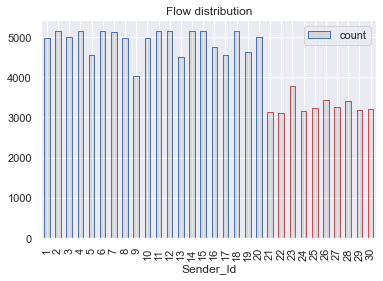

This is opposite to our assumption as our assumption dictates the attacker to attack nodes with high flows.
Here the attacker is attacking nodes with low flows as well


In [222]:
df_mirage = pd.read_csv("mirage_data_10.csv",header=0,skip_blank_lines=True, skipinitialspace=True)

print("Max timestep:",df_mirage["Time_Step"].max())

print("\n")
print("Total no. of transactions:", len(df_mirage))
print("No. of Fraud:", len(df_mirage[df_mirage["Label"]==1]))
print("No. of Non Fraud:", len(df_mirage[df_mirage["Label"]==0]))

# plot the flow distribution
c = ["b"] * len(df_mirage.groupby("Sender_Id").groups.keys())
for i in list(df_mirage[df_mirage["Label"]==1].groupby("Sender_Id").groups):
    c[i-1] = 'r'
df_mirage.groupby(["Sender_Id"]).size().to_frame('count').reset_index().plot.bar(x='Sender_Id', y='count', color=(0.1, 0.1, 0.1, 0.1), edgecolor=c)
plt.title("Flow distribution")
plt.show()

print("This is opposite to our assumption as our assumption dictates the attacker to attack nodes with high flows.") 
print("Here the attacker is attacking nodes with low flows as well")

Total no. of transactions: 23222


No. of Fraud: 1830
No. of Non Fraud: 21392


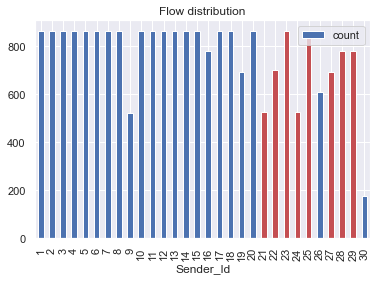

In the above plot, the red bars indicate accounts with fraudulent transactions
Note: Not all of them are fraudulent




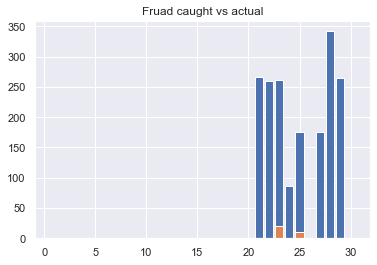

In [246]:
# group data into buckets of 10 timesteps 
df = df_mirage[(df_mirage["Time_Step"] > 10) & (df_mirage["Time_Step"] <= 20) ]

print("Total no. of transactions:", len(df))

print("\n")
print("No. of Fraud:", len(df[df["Label"] == 1]))
print("No. of Non Fraud:", len(df[df["Label"] == 0]))


c = ["b"] * len(df.groupby("Sender_Id").groups.keys())
for i in list(df[df["Label"]==1].groupby("Sender_Id").groups):
    c[i-1] = 'r'
    
df_flow = df.groupby(["Sender_Id"]).size().to_frame('count').reset_index()
df_flow.plot( x='Sender_Id', y='count', kind='bar', color = c)
plt.title("Flow distribution")
plt.show()
print("In the above plot, the red bars indicate accounts with fraudulent transactions")
print("Note: Not all of them are fraudulent")

# f is the flows which is outgoing edges for each client
f = df_flow['count'].tolist()
C_def = int(df_flow['count'].sum()*0.05)
C_att = int(df_flow['count'].sum()*0.01)
Eps = 10**-10


x, y, U_def, U_att, mu = solve_game(f, C_def, C_att, Eps, verbose=False)

fraud_actual_count = []
fraud_caught_count = []
for i in range(len(f)):
    # All transactions for client i+1
    df_sub = df[df["Sender_Id"]==i+1]
    # Randomly sample from all transactions for client i=1
    df_inspect = df_sub.sample(n=int(round((f*x)[i])), random_state=7)
    fraud_actual_count.append(len(df_sub[df_sub["Label"]==1]))
    fraud_caught_count.append(len(df_inspect[df_inspect["Label"]==1]))
    
print("\n")
plt.bar(range(1, len(fraud_actual_count)+1), fraud_actual_count)
plt.bar(range(1, len(fraud_actual_count)+1), fraud_caught_count)
plt.title("Fruad caught vs actual")
plt.show()

In [35]:
df_mirage = pd.read_csv("mirage_data_10.csv",header=0,skip_blank_lines=True, skipinitialspace=True)
df_mirage['Label_new'] = 0

random.seed(7)
accounts_to_attack = []
n = 10
choice = 2

if choice == 1:
    print("Case 1: pick n accounts with highest flows to attack")
    accounts_to_attack = df_mirage.groupby(["Sender_Id"]).size().to_frame('count').reset_index().sort_values("count", ascending=False)["Sender_Id"].head(n).tolist()
    df_mirage.loc[df_mirage[df_mirage["Sender_Id"].isin(accounts_to_attack)].sample(len(df_mirage[df_mirage["Label"]==1]), random_state=10).index.values, "Label_new"]=1
elif choice == 2:
    print("Case 2: pick n accounts at random to attack")
    for i in range(n):
        accounts_to_attack.append(random.randint(1,30))
    df_mirage.loc[df_mirage[df_mirage["Sender_Id"].isin(accounts_to_attack)].sample(len(df_mirage[df_mirage["Label"]==1]), random_state=10).index.values, "Label_new"]=1
elif choice == 3:
    print("Case 3: assign label randomly")
    df_mirage.loc[df_mirage.sample(len(df_mirage[df_mirage["Label"]==1]), random_state=10).index.values, "Label_new"]=1
elif choice == 4:
    print("Case 4: Retaining original Label")
    df_mirage['Label_new'] = df_mirage['Label']
    
@interact
def get_dataframe(column="Time_Step", C_defense = (0, 1, 0.05), start = widgets.IntSlider(min=1, max=101, step=1, value=11), end = widgets.IntSlider(min=1, max=101, step=1, value=20)):
    temp_df = df_mirage[(df_mirage["Time_Step"] >= start) & (df_mirage["Time_Step"] <= end) ] 
    
    c = ["b"] * len(temp_df.groupby("Sender_Id").groups.keys())
    for i in list(temp_df[temp_df["Label_new"]==1].groupby("Sender_Id").groups):
        c[i-1] = 'r'
    temp_df_flow = temp_df.groupby(["Sender_Id"]).size().to_frame('count').reset_index()
    plt.bar(temp_df_flow["Sender_Id"].tolist(), temp_df_flow["count"].tolist(), color=(0.1, 0.1, 0.1, 0.1), edgecolor=c)
    #plt.figure(figsize=(10,10))
    plt.title("Flow distribution")
    
    # f is the flows which is outgoing edges for each client
    f = temp_df_flow['count'].tolist()
    C_def = int(temp_df_flow['count'].sum()*C_defense)
    C_att = len(temp_df[temp_df["Label_new"]==1])
    
    print("C defence: {}, C attack:{}".format(C_def, C_att))
    
    Eps = 10**-10


    x, y, U_def, U_att, mu = solve_game(f, C_def, C_att, Eps, verbose=False)
    
    print("Defender Strategy:")
    print(f*x)
    
    fraud_actual_count = []
    fraud_caught_count = [] 
    
    fraud_caught_count_2 = []# proportional sample random
    
    # Uniformly Sampling
    df_inspect_1 = temp_df.sample(n=C_def, random_state=7)
    fraud_caught_count_1 = len(df_inspect_1[df_inspect_1["Label_new"]==1]) #uniformly random
    
    for i in range(len(f)):
        # All transactions for client 1 to 30
        df_sub = temp_df[temp_df["Sender_Id"]==i+1]

        # Randomly sample from all transactions for client i=1 to 30 as per x*f
        df_inspect = df_sub.sample(n=int(round((f*x)[i])), random_state=7)
        
        # Proportional sampling
        z = [int(np.floor((i / sum(f))*temp_df_flow['count'].sum()*C_defense)) for i in f]
        #print(temp_df_flow['count'].sum()*C_defense)
        #print(sum(z))
        df_inspect_2 = df_sub.sample(n=z[i], random_state=7)
        
        
        fraud_actual_count.append(len(df_sub[df_sub["Label_new"]==1]))
        fraud_caught_count.append(len(df_inspect[df_inspect["Label_new"]==1]))
        fraud_caught_count_2.append(len(df_inspect_2[df_inspect_2["Label_new"]==1]))
        
    print("\n")
    print("Fraud caught if we sample:")
    print("\t -as per strategy generated by game: {}/{}, {:.2f}%".format(sum(fraud_caught_count), sum(fraud_actual_count), (sum(fraud_caught_count)/sum(fraud_actual_count))*100))
    print("\t -uniformly from all transactions: {}/{}, {:.2f}%".format(fraud_caught_count_1, sum(fraud_actual_count), (fraud_caught_count_1/sum(fraud_actual_count))*100))
    print("\t -proportional to client flows: {}/{}, {:.2f}%".format(sum(fraud_caught_count_2), sum(fraud_actual_count), (sum(fraud_caught_count_2)/sum(fraud_actual_count))*100))
    
    #plt.bar(range(1, len(fraud_actual_count)+1), f*x)
    plt.bar(range(1, len(fraud_actual_count)+1), fraud_actual_count)
    plt.bar(range(1, len(fraud_actual_count)+1), fraud_caught_count)
    
    
    return df_mirage[(df_mirage["Time_Step"] >= start) & (df_mirage["Time_Step"] <= end)]

Case 2: pick n accounts at random to attack


interactive(children=(Text(value='Time_Step', description='column'), FloatSlider(value=0.0, description='C_def…